In [431]:
import sys, os

notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, "../.."))

if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

print("Added to sys.path:", root_dir)

Added to sys.path: c:\Users\ndhaj\Desktop\gpie


In [432]:
import numpy as np
import matplotlib.pyplot as plt

from examples.io_utils import load_sample_image
from examples.ptychography.data.dataset import PtychographyDataset
from examples.ptychography.simulator.scan import generate_raster_positions
from examples.ptychography.simulator.probe import generate_probe
from examples.ptychography.algorithms.pie import PIE

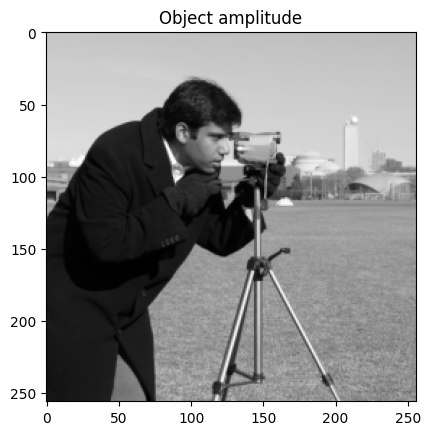

In [433]:
# --- 1. サンプル画像のロード ---
img = load_sample_image("camera", shape=(256, 256))
obj = img * np.exp(1j * np.zeros_like(img))  # 振幅のみのオブジェクト
plt.imshow(np.abs(obj), cmap="gray")
plt.title("Object amplitude")
plt.show()

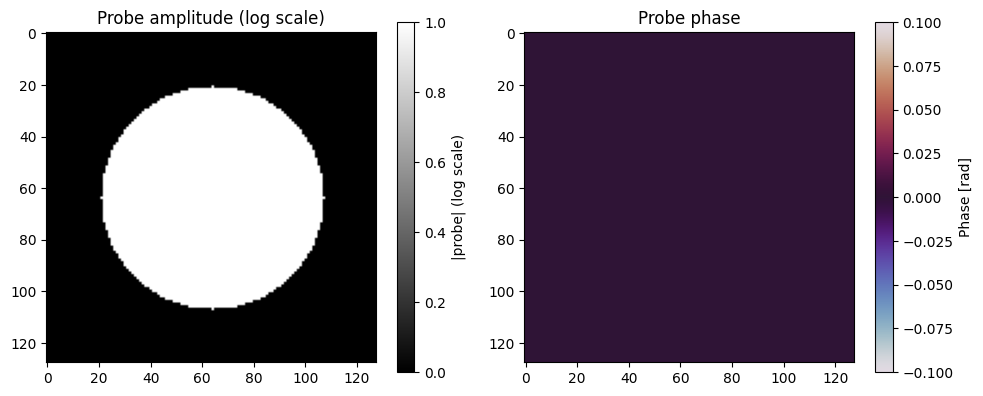

In [434]:
# ---- probe: circular aperture in *real space* (radius = 16 px) ----
prb_shape = (128,128)
yy, xx = np.meshgrid(
        np.arange(prb_shape[0]) - prb_shape[0] / 2,
        np.arange(prb_shape[1]) - prb_shape[1] / 2,
        indexing="ij",)
r = np.sqrt(xx**2 + yy**2)
aperture_radius = 43.0
prb_amp = np.where(r <= aperture_radius, 1.0, 0.0).astype(np.float32)
probe = prb_amp.astype(np.complex64)  # purely real amplitude probe

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
amp = np.abs(probe)
plt.imshow(amp, cmap="gray")
plt.title("Probe amplitude (log scale)")
plt.colorbar(label="|probe| (log scale)")

plt.subplot(1, 2, 2)
plt.imshow(np.angle(probe), cmap="twilight")
plt.title("Probe phase")
plt.colorbar(label="Phase [rad]")

plt.tight_layout()
plt.show()

In [435]:
# --- 3. PtychographyDatasetの構築 ---
ds = PtychographyDataset()
ds.set_object(obj.astype(np.complex64))
ds.set_probe(probe.astype(np.complex64))
ds.set_pixel_size(1.0)

# スキャンパターンを設定（例：5x5ラスタースキャン）
scan_gen = generate_raster_positions(stride_um=20.0)
ds.simulate_diffraction(scan_gen, max_num_points=49, noise=1e-6)

print(f"Generated {len(ds)} diffraction patterns.")

# --- 4. PIE再構成の実行 ---
pie = PIE(dataset=ds, alpha=0.1)

# 進行状況を可視化するためのコールバック関数
def callback(it, err, obj):
    if it % 5 == 0:
        print(f"Iteration {it:03d}: error = {err:.4e}")

pie.callback = callback

Generated 49 diffraction patterns.


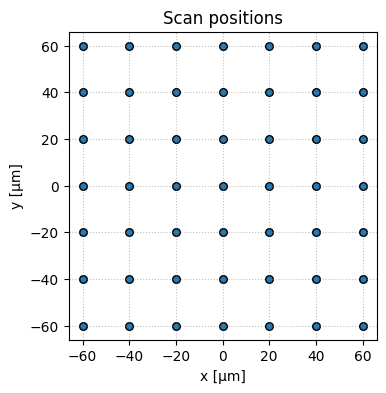

In [436]:
fig = ds.show_scan_positions()

Iteration 000: error = 5.4802e-02
Iteration 005: error = 1.8177e-04
Iteration 010: error = 7.6929e-06
Iteration 015: error = 1.7561e-06
Iteration 020: error = 1.2654e-06
Iteration 025: error = 1.1998e-06
Iteration 030: error = 1.1891e-06
Iteration 035: error = 1.1885e-06
Iteration 040: error = 1.1885e-06
Iteration 045: error = 1.1885e-06
Iteration 050: error = 1.1885e-06
Iteration 055: error = 1.1885e-06
Iteration 060: error = 1.1885e-06
Iteration 065: error = 1.1885e-06
Iteration 070: error = 1.1885e-06
Iteration 075: error = 1.1885e-06
Iteration 080: error = 1.1885e-06
Iteration 085: error = 1.1885e-06
Iteration 090: error = 1.1885e-06
Iteration 095: error = 1.1885e-06


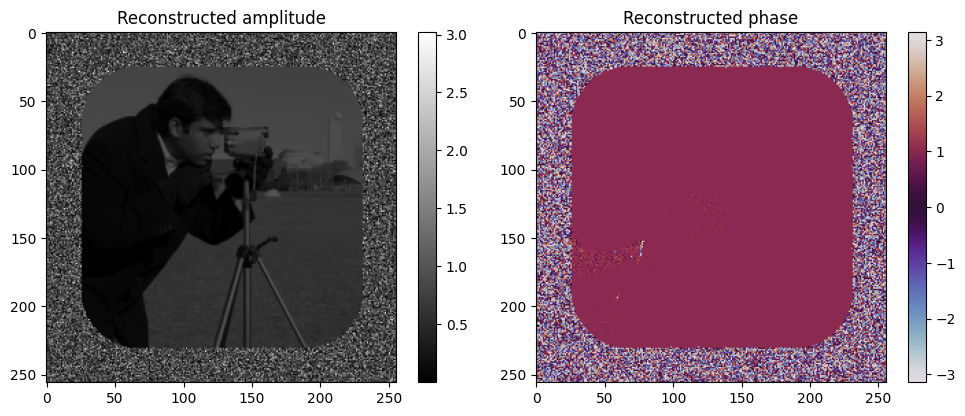

In [437]:
recon_pie = pie.run(n_iter=100)

# --- 5. 結果の可視化 ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(recon_pie), cmap="gray")
plt.title("Reconstructed amplitude")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.angle(recon_pie), cmap="twilight")
plt.title("Reconstructed phase")
plt.colorbar()
plt.tight_layout()
plt.show()

In [438]:
from gpie import model, Graph, GaussianPrior, AmplitudeMeasurement, fft2, pmse
from gpie.core.backend import np
from gpie.core.rng_utils import get_rng
import numpy as np

In [439]:
@model
def ptychography_graph_known_probe(
    obj_shape,
    prb,                          # probeは既知のnumpy/cupy配列
    indices,
    noise: float,
    dtype=np.complex64,
    damping: float = 0.0,
):
    """Ptychography graph with known probe."""
    obj = ~GaussianPrior(event_shape=obj_shape, label="object", dtype=dtype)
    patches = obj.extract_patches(indices)
    exit_waves = prb * patches  # probeを定数として掛ける
    AmplitudeMeasurement(var=noise, label="meas", damping=damping) << fft2(exit_waves)
    return

In [440]:
g = ptychography_graph_known_probe(
    obj_shape = ds.obj_shape,
    prb = ds.prb,
    indices = [d.indices for d in ds._diff_data],
    noise = ds._diff_data[0].noise,
)

In [441]:
obj = g.get_wave("object")
obj.set_sample(ds.obj)
g.generate_sample()

In [442]:
g.set_init_rng(get_rng(20))
g.run(n_iter=100)

In [443]:
obj = g.get_wave("object")
recon_gpie = obj.compute_belief().data[0]

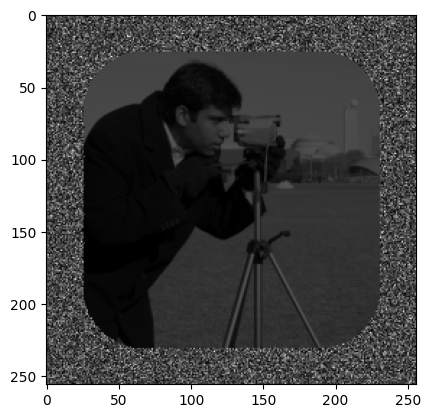

In [444]:
plt.imshow(np.abs(recon_pie), cmap = "gray")

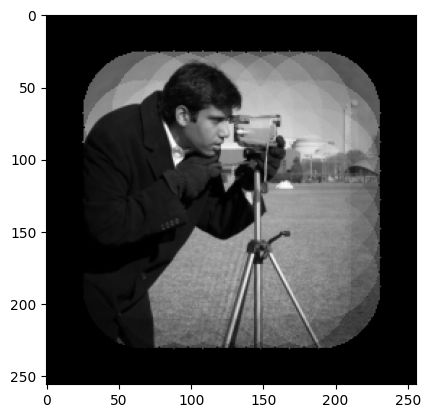

In [445]:
plt.imshow(np.abs(recon_gpie), cmap = "gray")

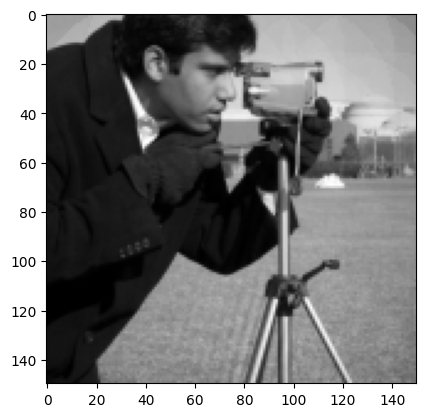

In [446]:
plt.imshow(np.abs(recon_gpie[50:200, 50:200]), cmap = "gray")

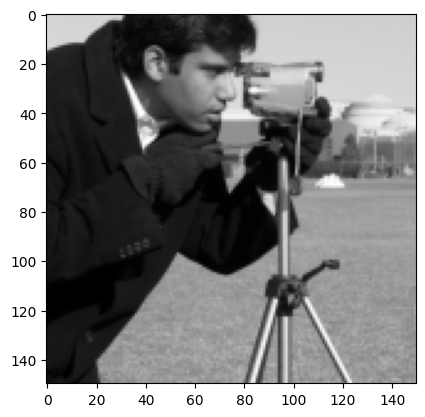

In [447]:
plt.imshow(np.abs(recon_pie[50:200, 50:200]), cmap = "gray")